## Spider Chart

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [2]:
def example_data():
    data = [
        ['12', '11', '10', '09', '08', '07', '06', '05', '04', '03', '02', '01'],
        ('Minggu', [
            [0.90]*3+[0.98]*3+[0.95]*3+[0.91]*3,
            [0.77]*12]),
        ('Senin', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12]),
        ('Selasa', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12]),
        ('Rabu', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12]),
        ('Kamis', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12]),
        ('Jumat', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12]),
        ('Sabtu', [
            [0.18]*3+[0.18]*3+[0.88]*3+[0.01]*3,
            [0.77]*12])
    ]
    return data

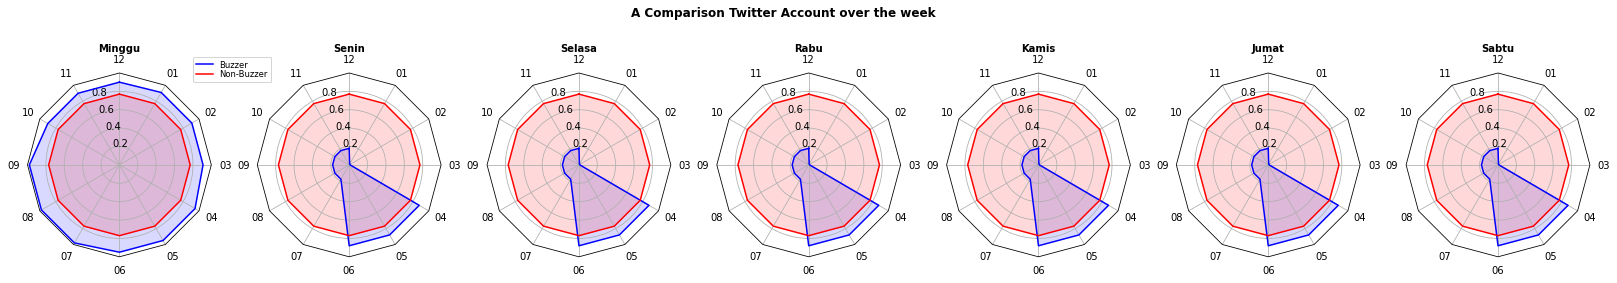

In [3]:
if __name__ == '__main__':
    N = 12
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(28, 4), nrows=1, ncols=7,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_rlim([0.0, 1.0])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.15)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0]
    labels = ('Buzzer', 'Non-Buzzer')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'A Comparison Twitter Account over the week',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()